## Installations and imports
As is standard with QGC notebooks, we would like to install the Qiskit and Qiskit-Aer libraries.  Certain functionality in the notebook may require ipykernel or matplotlib.  Code will use the former two libraries, which is why those are what's imported.

In [ ]:
!pip install --no-cache-dir qiskit
!pip install --no-cache-dir qiskit-Aer
!pip install ipykernel
!pip install matplotlib

In [3]:
from qiskit import *
from qiskit.visualization import *

# Random walk

In a discrete, classical world, a random walk involves something moving about a space randomly, moving one unit of distance in some random direction with every time step.  In the most generic case, the random walk takes place on a set of connected nodes, and the walker moves from one node to a connected one each time-step.  These nodes can be connected in any fashion; however, certain cases are more convenient.

One of the more traditional classical cases involves motion in some dimensional space, where the walker can move forward or backward 1 in any random dimension each time-step.  This is equivalent to an infinite set of nodes connected in a grid fashion, and, owing to the uniformity of the connections, is easier to implement in quantum or classical computing.

The simplest case is, of course, one-dimensional space.  In this case the walker begins at some co-ordinate (which would reasonably be zero) and its position is randomly incremented or decremented by one each time-step.  We can represent the walker's position as a register of bits, which store the walker's position in two's-complement notation (e.g., 0000 for zero, 0001 for one, 1111 for negative one, 1110 for negative two, etc.)

## Example circuit:  Full Adder

In the two's complement notation, incrementation can be achieved by the use of a chain of half adders with initial carry-in one, while both incrementation and decrementation can be achieved by the use of a full adder, which adds the register to a register containing either one or negative one.  A full adder with its ancillary bits is shown below, also demonstrating the convenient way of making quantum "modules" out of quantum gates in Qiskit (namely, via a function that takes a circuit and some of its registers as arguments).

In [4]:
# Parameters:
# circuit - the QuantumCircuit containing the four registers given as arguments
# addend1 and addend2 - two QuantumRegisters of equal length, containing the numbers to input
# carrybits and sumbit - two QuantumRegisters of lengths 2 and one, used in calculations.
# Output: the resulting sum is stored in the space used by the first addend (to conserve qubits)
def full_add(circuit, addend1, addend2, carrybits, sumbit):
    circuit.initialize('00', carrybits)
    circuit.initialize('0', sumbit) # Carry bits [0] (at right) is the carry-in
    # Carry bits[1] (at left) is the carry-out

    for i in range(len(addend1)): # A full adder can be done with five gates and four bits, but I find this more intuitive
        circuit.cnot(addend1[i], sumbit) # Sum is the result of three cnots (parity counter)
        circuit.cnot(addend2[i], sumbit)
        circuit.cnot(carrybits[0], sumbit)

        circuit.toffoli(addend1[i], addend2[i], carrybits[1]) # Carry-out is the result of three Toffoli gates
        circuit.toffoli(carrybits[0], addend2[i], carrybits[1])
        circuit.toffoli(addend1[i], carrybits[0], carrybits[1])

        circuit.swap(carrybits[0], carrybits[1]) # Make the carry-out the carry-in (for the next bit)
        circuit.initialize('0', carrybits[1]) # Reset carry-out
        circuit.swap(sumbit, addend1[i]) # Store the sum in the first addend (we'll keep it)
        circuit.initialize('0', sumbit) # Reset sumbit

The code below allows one two try out the full adder.  One can determine the length of the registers by setting the REG_LENGTH parameter, and the quantity of the addends with the values in the indicated lines.

In [ ]:
REG_LENGTH = 6

num = QuantumRegister(REG_LENGTH)
add = QuantumRegister(REG_LENGTH)
car = QuantumRegister(2)
sum = QuantumRegister(1)
ans = ClassicalRegister(REG_LENGTH)
circuit = QuantumCircuit(num, add, car, sum, ans)

# Set added values here:
circuit.initialize('010110', num)
circuit.initialize('000100', add)
# The right-most 0 or 1 in the string is the register's [0] and should represent the least significant bit
# This is preserved in the appearing histogram.

full_add(circuit, num, add, car, sum)
circuit.measure(num, ans)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=10) # should always get same value
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## Hadamard coins
In order to make the full adder computer the results of the random walk, it must repeatedly add to the first number either one or negative one - randomly.  Doing this once can be achieved by setting the second addend, randomly, to either of those values - the last bit, always one; the remaining bits, always the same, but random.  This can be achieved using a Hadamard coin.

The Hadamard gate, applied to a newly initialized qubit in the 0 state, causes it to move (into the + state) such that it has equal probability of rendering as a zero or one.  This qubit can be called a "Hadamard coin," as can the structure making use of it.  When the Hadamard qubit is used as the control for a cx gate, the target qubit flips depending on how the Hadamard qubit renders; when it is used as the control for several cx gates, the target qubits all flip or all don't flip, because they were entangled with the same qubit.

The code sample below applies a Hadamard coin to all but the last bit in the second addend, which is set to one, and repeatedly re-flips and re-adds, implementing a simple, but not efficient, one-dimensional random walk.

In [ ]:
REG_LENGTH = 4
STEPS = 6

# Construct circuit
num = QuantumRegister(REG_LENGTH)
add = QuantumRegister(REG_LENGTH)
car = QuantumRegister(2)
sum = QuantumRegister(1)
ans = ClassicalRegister(REG_LENGTH)
coin = QuantumRegister(1)
circuit = QuantumCircuit(num, add, car, sum, ans, coin)
circuit.initialize('0'*REG_LENGTH, num)

# Operations
for step in range(STEPS):

    # Flip a coin
    circuit.initialize('0', coin)
    circuit.h(coin)

    # Set the last bit of my adder to one and change the rest based on the coin
    circuit.initialize('1', add[0])
    for r in range(1, REG_LENGTH):
        circuit.cnot(coin, add[r])
    
    # Add
    full_add(circuit, num, add, car, sum)

# Measurement and results
circuit.measure(num, ans)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## A more efficient implementation - incrementer and decremeter
It may be apparent that the full adder is more than is necessary to simply increment and decrement a register - this is true for classical circuits as well as quantum.  It is possible to perform each operation with only two ancillary qubits, rather than a second addend, which is what the code below does.

Put simply, an incrementer starts with the least significant bit and changes bits until it encounters a zero, which is the last bit it changes; while a decrementer starts with the least significant bit and changes bits until it encounters a one, which is the last bit it changes.  Below this is implement with both incrementer and decrementer having a QuantumRegister containing the number to -crement one way or another and one of length two containing an ancillary bit and a bit indicating how much is left to carry in (when adding) or borrow out (when subtracting).

Note that the incrementer and decrementer do not initialize the amount to carry in or borrow out to be one, as they would need to work, in general.  Their carry and borrow bits are set by the main circuit with each step to be different - one is a Hadamard coin; the other receives an X gate and is then the target of a CX gate controlled by the coin, producing two qubits of opposite values.  The operation that receives a "1" is performed.

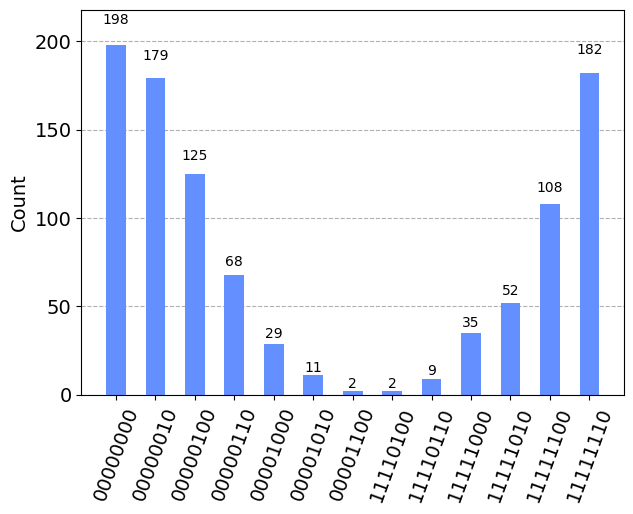

In [10]:
def incup(num, carry, circuit): # Given a quantum register of some length
    for i in range(len(num)):
        circuit.initialize('0', carry[1]) # Ground the carry bit - we want to know whether it should be one
        circuit.toffoli(carry[0], num[i], carry[1]) # Find the next carry - it's one iff both input carry and bit are one
        circuit.cnot(carry[0], num[i]) # Increment - change the value if there is carry
        circuit.swap(carry[0], carry[1]) # And next carry becomes new input carry

def incdown(num, borrow, circuit): # Given a quantum register of some length
    for i in range(len(num)):
        circuit.initialize('0', borrow[1]) # Ground the next borrow for next time

        circuit.cnot(borrow[0], borrow[1]) # If we have borrow now, we'll need to borrow again next time,
        circuit.toffoli(borrow[0], num[i], borrow[1]) # Unless we have one now as well.

        circuit.cnot(borrow[0], num[i]) # Perform subtraction - change number if borrowing

        circuit.swap(borrow[1], borrow[0]) # borrow from next is now our borrow;

# Parameters
REG_LENGTH = 8
STEPS = 16

# Construct circuit
num = QuantumRegister(REG_LENGTH)
car = QuantumRegister(2)
bor = QuantumRegister(2)
ans = ClassicalRegister(REG_LENGTH)
circuit = QuantumCircuit(num, car, bor, ans)
circuit.initialize('0'*REG_LENGTH, num)

# Operations
for step in range(STEPS):

    # Set bor[0] and car[0] to be opposite each other
    circuit.initialize('0', bor[0])
    circuit.initialize('1', car[0])
    circuit.h(bor[0])
    circuit.cnot(bor[0], car[0])

    # Take a step
    incdown(num, bor, circuit)
    incup(num, car, circuit)

circuit.measure(num, ans) # View results

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

It is pleasant to see the result of this, which should resemble a binomial distribution.

A few remarks regarding the classical solution:
* At any time t, the walker may be from -t to t
* The probability of being at any position x within that range is the probabilty that the number of total steps forward, minus the number of total steps backwards, yields that position.  Since the number of total steps forward and the number of total steps backward add up to the number of total steps, which is fixed, there is a fixed number of each that must occur to cause each position: $(t-x)/2$ steps back and $(t+x)/2$ steps forward.
* Assuming the number of steps taken t and a position x have the same parity (as that is also necessary for a position to be possible at time t), the probability of the correct number of steps occuring is $\binom{t}{\frac{t-x}{2}}(\frac{1}{2})^{\frac{t-x}{2}}(\frac{1}{2})^{\frac{t+x}{2}} = \binom{t}{\frac{t-x}{2}}(\frac{1}{2})^t = \binom{t}{\frac{t+x}{2}}(\frac{1}{2})^t$, effectively a binomial distribution of width t and probability parameter one-half, staggered back by t/2 and stretched by two.
* Owing to being split over the x=0 line, and matplotlib's interpretation of the register as being an unsigned value, the binomial distribution appears cut in half in the graph above.

## Biaxial version
The same mechanics can be used to create a bi-axial version, or a walk about the discrete Cartesian co-ordinate plane.

In this version, the random walker may walk north, south, east, or west on each time-step - there are two registers, one representing an 'x' (east-west) co-ordinate, the other a 'y' (north-south) co-ordinate, each with two -crementers, and only one of the four is to run at a time.

To implement this, it is of course necessary to use two Hadamard coins (a 4-sided Hadamard dice?) - which, flipped independently, produce 00, 01, 10, or 11 with equal odds.  The carry and borrow bits of the incrementers and decrementers can then be set by connecting that to a 2-to-4 decoder module, which then produces 0001, 0010, 0100, or 1000 with equal frequency, as the code snippet below demonstrates.

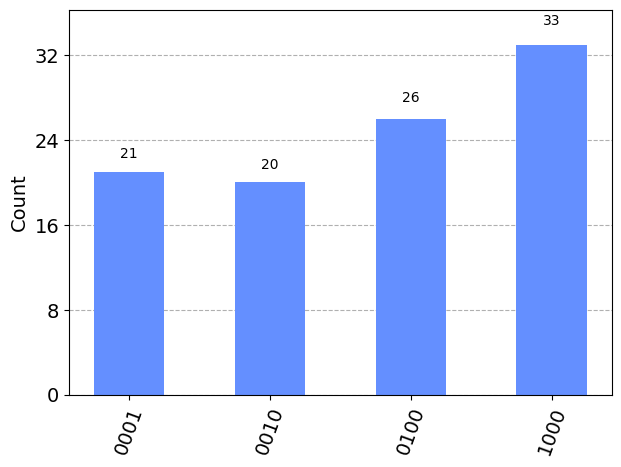

In [8]:
# A two-to-four decoder, in the classical style, has the following inputs and outputs:
# Input | Output
# 00    | 0001
# 01    | 0010
# 10    | 0100
# 11    | 1000
def decode2to4(circuit, in_r, out_r):
    circuit.initialize('0000', out_r)

    circuit.x(out_r[0])
    circuit.cx(in_r[0], out_r[0])
    circuit.cx(in_r[1], out_r[0])
    circuit.toffoli(in_r[0], in_r[1], out_r[0])

    circuit.cx(in_r[0], out_r[1])
    circuit.toffoli(in_r[0], in_r[1], out_r[1])

    circuit.cx(in_r[1], out_r[2])
    circuit.toffoli(in_r[0], in_r[1], out_r[2])

    circuit.toffoli(in_r[0], in_r[1], out_r[3])

def flip_coins(circuit, coins):
    circuit.initialize('0'*len(coins), coins)
    for c in coins:
        circuit.h(c)

# Construct circuit
coins = QuantumRegister(2)
choice = QuantumRegister(4)
choice_show = ClassicalRegister(4)
circuit = QuantumCircuit(coins, choice, choice_show)

# Perform operations
flip_coins(circuit, coins)
decode2to4(circuit, coins, choice)

# Results
circuit.measure(choice, choice_show)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)


The above functions are applied to the circuit below, which performs the bi-axial walk.

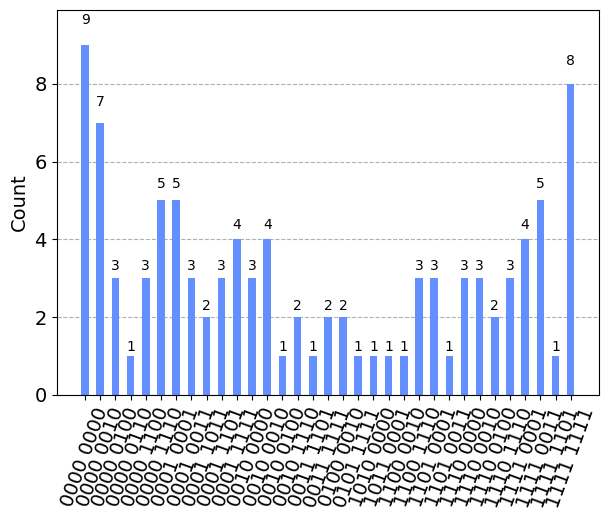

In [11]:
# Biaxial version
AXIS_LENGTH = 4 # In qubits; e.g., 4 is 16
STEPS = 8

coins = QuantumRegister(2)
choice = QuantumRegister(4)
ancil = QuantumRegister(4)
x_qr = QuantumRegister(AXIS_LENGTH)
y_qr = QuantumRegister(AXIS_LENGTH)
x_cr = ClassicalRegister(AXIS_LENGTH)
y_cr = ClassicalRegister(AXIS_LENGTH)
biaxircuit = QuantumCircuit(coins, choice, ancil, x_qr, y_qr, x_cr, y_cr)

for s in range(STEPS):
    flip_coins(biaxircuit, coins)
    decode2to4(biaxircuit, coins, choice)

    incup(x_qr, [choice[0], ancil[0]], biaxircuit)
    incdown(x_qr, [choice[1], ancil[1]], biaxircuit)
    incup(y_qr, [choice[2], ancil[2]], biaxircuit)
    incdown(y_qr, [choice[3], ancil[3]], biaxircuit)

biaxircuit.measure(x_qr, x_cr)
biaxircuit.measure(y_qr, y_cr)

job = execute(biaxircuit, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)
    
    



### Plotting results of a bi-axial walk
If we want to make that prettier, we can look at what exactly "counts" is - it's of the type qiskit.result.counts.Counts, which behaves like a dictionary in which the keys are what we see on the x-axis of the graph above (as strings) and the entries are the heights of their bars.  The code below uses matplotlib to convert those into x- and y-coordinates and plots the results.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

# Python's built-in binary to integer conversion doesn't account for signed values - do so with these:
CORRECTION_SLIDE = (2 ** AXIS_LENGTH)
MAX = CORRECTION_SLIDE / 2 - 1

x = []
y = []
val = []
for each in counts:
    xb, yb = each.split(' ') # Retrieve binary coordinates
    xi, yi = int(xb, 2), int(yb, 2) # Convert to integer
    if (xi > MAX): xi -= CORRECTION_SLIDE # Render integers accurate
    if (yi > MAX): yi -= CORRECTION_SLIDE
    x.append(xi) # Add to lists of coordinates
    y.append(yi)
    val.append(counts[each])

Text(0.5, 0.92, 'Bi-axial quantum walk results')

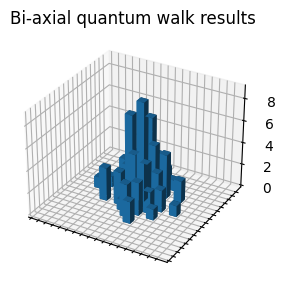

In [26]:
# set up the figure and axes
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(121, projection='3d')

bottom = np.zeros_like(val)
width = depth = 1

# In a 3D bar chart, x and y are coordinates on the ground, bottom is where the bars start,
# width and depth are the dimensions of the bars, and val is the important parameters.
ax.bar3d(x, y, bottom, width, depth, val, shade=True)

# Focus around the possible range.  Mark all ticks and do not label.
ax.set_xlim([-STEPS-1,STEPS+1])
ax.set_ylim([-STEPS-1,STEPS+1])
ax.set_xticks(range(-STEPS-1, STEPS+1))
ax.set_yticks(range(-STEPS-1, STEPS+1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Bi-axial quantum walk results')

### Conclusion
However, it is also noticeable that the difficult-to-view data is not the only flaw of the bi-axial walk model.  There are very many gates, which contributes greatly to the implementation time.  And of course, many of those gates - perhaps three-fourths of them - don't do anything.  None of the advantages of quantum computing (besides Hadamard coins) were used in this tutorial.  Quantum computing is, however, capable of exponentially speeding up calculation times for certain random walks; in our next notebook, we will explore how.